In [1]:
import sys 
sys.path.append('/home/lumargot/trachoma/src/py')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # put -1 to not use any
from torch import Tensor, nn
import torchvision

import onnx

In [2]:
from loaders.tt_dataset import BBXImageTestTransform, BBXImageEvalTransform, TTDataModuleBX
import SimpleITK as sitk
from nets.segmentation import FasterTTRCNN, TTRPN
import torch
import numpy as np
from nets.segmentation import FasterTTRCNN
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle

import tensorflow as tf
import onnxruntime as ort
import numpy as np
import pandas as pd 
from visualization import *
from evaluation import *
from utils import *


from collections import OrderedDict

2025-07-14 08:49:26.182934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752497366.196254  387948 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752497366.200255  387948 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752497366.211008  387948 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752497366.211021  387948 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752497366.211023  387948 computation_placer.cc:177] computation placer alr

In [3]:
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v4/fold2/epoch=20-val_loss=1.83.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_batch/fold2/epoch=19-val_loss=1.85.ckpt' #best!


In [4]:
ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v2/fold0/epoch=12-val_loss=2.08.ckpt'

In [5]:
def plot_patches(img, targets, title='ground truth'):
  ax = plt.gca()
  ax.imshow(img)
  ax.set_title(title)

  boxes = targets['boxes']
  labels = targets['labels']

  print(f"Found {labels.shape[0]} data points")

  for j in range(labels.shape[0]):
    box = boxes[j]
    label = labels[j]

    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    if label == 1:
      color = 'yellow'
    elif label == 2:
      color = 'blue'
    else:
      color = 'cyan'

    rect = Rectangle((x1, y1), width, height, fill=False, color=color, linewidth=1.5)
    ax.add_patch(rect)


In [6]:
from torchvision.ops import boxes as box_ops, roi_align
import torch.nn.functional as F

In [7]:

class TTRoidHead(nn.Module):
    def __init__(self, faster):
        super(TTRoidHead, self).__init__()
        self.faster = faster
        self.images_shapes = None
        self.og_sizes = None

    def resize_boxes(self, boxes):
        ratios = [
            torch.tensor(s, dtype=torch.float32, device=boxes.device)
            / torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
            for s, s_orig in zip(self.og_sizes[0], self.images_shapes[0])
        ]
        ratio_height, ratio_width = ratios
        xmin, ymin, xmax, ymax = boxes.unbind(1)
        
        xmin = xmin * ratio_width
        xmax = xmax * ratio_width
        ymin = ymin * ratio_height
        ymax = ymax * ratio_height
        return torch.stack((xmin, ymin, xmax, ymax), dim=1)


    def forward(self, images, proposals, targets=None):

        original_image_sizes: list[tuple[int, int]] = []
        for img in images:
            val = img.shape[-2:]
            torch._assert(
                len(val) == 2,
                f"expecting the last two dimensions of the Tensor to be H and W instead got {img.shape[-2:]}",
            )
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.faster.transform(images, targets)
        self.images_shapes = images.image_sizes
        self.og_sizes = original_image_sizes

        features = self.faster.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])

        roi_out = self.faster.roi_heads.box_roi_pool(features, proposals, images.image_sizes)
        box_features = self.faster.roi_heads.box_head(roi_out)
        class_logits, box_regression = self.faster.roi_heads.box_predictor(box_features)
        # boxes, scores, labels = self.faster.roi_heads.postprocess_detections(class_logits, box_regression, proposals, images.image_sizes)

        device = class_logits.device
        num_classes = class_logits.shape[-1]

        boxes_per_image = [boxes_in_image.shape[0] for boxes_in_image in proposals]
        pred_boxes = self.faster.roi_heads.box_coder.decode(box_regression, proposals)

        pred_scores = F.softmax(class_logits, -1)

        pred_boxes_list = pred_boxes.split(boxes_per_image, 0)
        pred_scores_list = pred_scores.split(boxes_per_image, 0)

        all_boxes = []
        all_scores = []
        all_labels = []
        for boxes, scores, image_shape in zip(pred_boxes_list, pred_scores_list, images.image_sizes):
            boxes = box_ops.clip_boxes_to_image(boxes, image_shape)

            # create labels for each prediction
            labels = torch.arange(num_classes, device=device)
            labels = labels.view(1, -1).expand_as(scores)

            scores, labels = torch.max(scores, dim=1)
            batch_indices = torch.arange(boxes.size(0), device=boxes.device)
            
            boxes = boxes[batch_indices, labels]
            
            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)


        detections = []
        num_images = len(all_labels)
        for i in range(num_images):
            detections.append(
                {
                    "boxes": all_boxes[i],
                    "labels": all_labels[i],
                    "scores": all_scores[i],
                }
            )
        
        return self.resize_boxes(detections[0]['boxes']), detections[0]['labels'], detections[0]['scores']


## data loading

In [8]:
# === old === #
mount_point = "/CMF/data/lumargot/trachoma/"
df_test = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_test.csv')

concat_labels=['overcorrection', 'ECA', 'Gap', 'Fleshy']
drop_labels = ['Short Incision', 'Reject']

img_column= "filename" 
class_column = 'class'
label_column = 'label'

df_test = remove_labels(df_test, class_column, label_column, drop_labels=drop_labels, concat_labels=concat_labels)

map ={ 1:'Healthy', 2:'Entropion', 3:'Overcorrection'}

ttdata = TTDataModuleBX(df_test, df_test, df_test, batch_size=1, num_workers=1, img_column='filename',severity_column='sev', 
                        mount_point=mount_point, class_column= class_column,
                        train_transform=BBXImageTestTransform(height=666, width=1333), 
                        valid_transform=BBXImageTestTransform(height=666, width=1333), 
                        test_transform=BBXImageTestTransform(height=666, width=1333))
ttdata.setup()
dataload = ttdata.test_dataloader()
ds = ttdata.test_ds

In [9]:
# img_path = os.path.join('/CMF/data/lumargot/trachoma/', df_test.iloc[3830]['filename'])
# img = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(img_path)).copy())).to(torch.float32)

# img = img.permute((2, 0, 1))
# img = img/255.0
# img_cropped = img[:, 1500:3000,:]
# tr = torchvision.transforms.Resize(size=(1333, 666))
# img_resize = tr(img)

example_input = ds[0]['img']

In [10]:
example_input.shape

torch.Size([3, 666, 1333])

In [11]:
model = FasterTTRCNN(out_features=4, class_weights = torch.ones(4))
state_dict = torch.load(ckpt, weights_only=False, map_location='cpu') # or 'cuda' if loading to GPU
model.load_state_dict(state_dict['state_dict'])
model.eval()

rpn = TTRPN(model.model)
rpn.eval()
prpl_og = rpn(example_input.unsqueeze(0).cpu())

roi_head = TTRoidHead(model.model)
roi_head.eval()
boxes_og, labels_og, scores_og = roi_head(example_input.unsqueeze(0).cpu(), prpl_og)


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Create ROI head ONNX model

#### rpn model

In [12]:
# rpn_onnx_path = "model_512/rpn/rpn_p1.onnx"
rpn_onnx_path = 'rpn_p2_v2.onnx'

# # Export the model
torch.onnx.export(
    rpn.cpu(),  # model being run
    (example_input.unsqueeze(0).cpu()),  # model input (or a tuple for multiple inputs)
    rpn_onnx_path,  # where to save the model (can be a file or file-like object)
    do_constant_folding=True,
    export_params=True,
    opset_version=18,
    input_names=["input", "proposals"],  # the model's input names
    output_names=["proposals"],
)

Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Exporting aten::index operator of advanced indexing in opset 18 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incor

In [13]:
# roi_onnx_path = "model_512/roi/roi_p2.onnx"
roi_onnx_path = "roi_p1_v2.onnx"
# # Export the model
torch.onnx.export(
    roi_head.cpu(),  # model being run
    (example_input.unsqueeze(0).cpu(), [prpl_og[0].cpu()]),  # model input (or a tuple for multiple inputs)
    roi_onnx_path,  # where to save the model (can be a file or file-like object)
    do_constant_folding=True,
    export_params=True,
    opset_version=18,
    input_names=["input", "proposals"],  # the model's input names
    output_names=["boxes", "labels", "scores"],
)

Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
torch.tensor results are registered as constants in the trace. You can

In [14]:
# full_onnx_path = "test_full_model_v2.onnx"

# torch.onnx.export(
#     full_model.cpu(),  # model being run
#     (example_input.cpu()),  # model input (or a tuple for multiple inputs),
#     full_onnx_path,
#     do_constant_folding=True,
#     export_params=True,
#     opset_version=18,
#     input_names=["input"],  # the model's input names
#     output_names=["boxes", "labels", "scores"],
# )

### Load both ONNX Models (RPN, ROI) for visualization

In [15]:
# Load  ONNX models
session_rpn = ort.InferenceSession(rpn_onnx_path)
session_roi = ort.InferenceSession(roi_onnx_path)

# 1st step: ROI
input_name = session_rpn.get_inputs()[0].name
output_name = session_rpn.get_outputs()[0].name

prpl_onnx = session_rpn.run([output_name], {input_name: example_input.unsqueeze(0).numpy()})

# 2nd step: ROI head
input_name_0 = session_roi.get_inputs()[0].name
input_name_1 = session_roi.get_inputs()[1].name

output_name_0 = session_roi.get_outputs()[0].name
output_name_1 = session_roi.get_outputs()[1].name
output_name_2 = session_roi.get_outputs()[2].name

boxes_onnx, labels_onnx, scores_onnx = session_roi.run([output_name_0, output_name_1, output_name_2], 
                                        {input_name_0: example_input.unsqueeze(0).numpy(), input_name_1:prpl_onnx[0]})

full model

In [ ]:
# # Load  ONNX models
# session_fm = ort.InferenceSession(full_onnx_path)

# # 1st step: ROI
# input_name = session_fm.get_inputs()[0].name

# output_name_0 = session_fm.get_outputs()[0].name
# output_name_1 = session_fm.get_outputs()[1].name
# output_name_2 = session_fm.get_outputs()[2].name

# boxes_onnx, labels_onnx, scores_onnx = session_fm.run([output_name_0, output_name_1, output_name_2], 
#                                         {input_name_0: example_input.numpy() })

### Create TFlite model

In [ ]:
# run in terminal onnx2tf -i faster.onnx -prf param.json -b 1 -ois input:1,3,768,1536 -onwdt
# with encapsulation needed to changed the operator name 
# onnx2tf -i roi_debug.onnx -prf roi_head.json -b 1 -ois 'input:1,3,666,1333' 'proposals:100,4' -onwdt  -o roi_debug -cotof -nlt

### Load TFLite models

In [22]:
## load RPN
tf_rpn_path = 'rpn_v2/rpn_p2_v2_float32.tflite'
tf_roi_path = 'roi_v2/roi_p1_v2_float32.tflite'

itp_rpn = tf.lite.Interpreter(model_path=tf_rpn_path,  
                              experimental_delegates=[])


itp_rpn.allocate_tensors()

# Get input and output tensors.
input_details = itp_rpn.get_input_details()
output_details = itp_rpn.get_output_details()

itp_rpn.set_tensor(input_details[0]['index'], example_input.unsqueeze(0).permute(0,2,3,1))
itp_rpn.invoke()

prpl_tf = itp_rpn.get_tensor(output_details[0]['index'])

In [23]:
## load ROI head 
itp_roi = tf.lite.Interpreter(model_path=tf_roi_path, experimental_delegates=[],)
itp_roi.allocate_tensors()

input_details = itp_roi.get_input_details()
output_details = itp_roi.get_output_details()

itp_roi.set_tensor(input_details[0]['index'], example_input.unsqueeze(0).permute(0,2,3,1))
itp_roi.set_tensor(input_details[1]['index'], prpl_tf)
itp_roi.invoke()

boxes_tf = itp_roi.get_tensor(output_details[0]['index'])
labels_tf = itp_roi.get_tensor(output_details[1]['index'])
scores_tf = itp_roi.get_tensor(output_details[2]['index'])

INFO: Created TensorFlow Lite delegate for select TF ops.
I0000 00:00:1752497969.138523  387948 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46709 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:43:00.0, compute capability: 8.6
INFO: TfLiteFlexDelegate delegate: 4 nodes delegated out of 525 nodes with 1 partitions.



### Visualize RPN's outputs

Found 100 data points
Found 100 data points
Found 100 data points


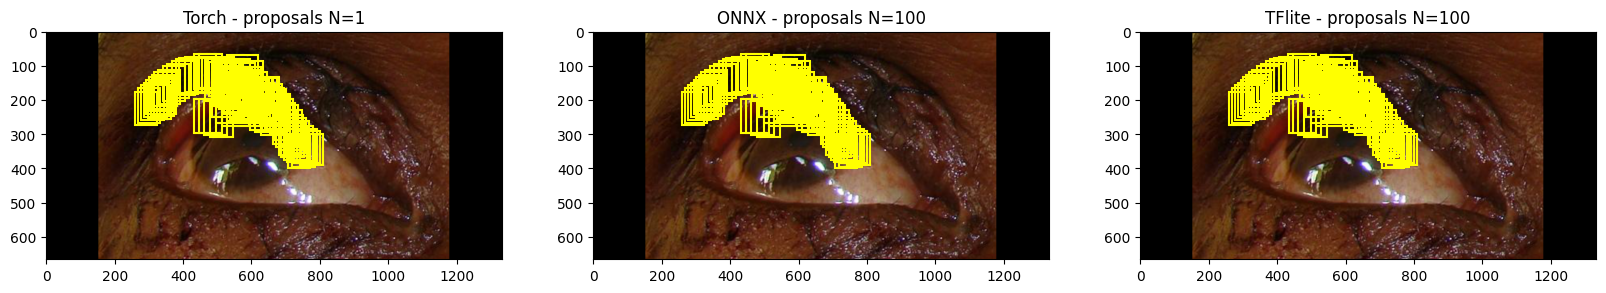

In [25]:
plt.figure(figsize=(20,10))

preds_og = {'boxes': prpl_og[0],  'labels':torch.ones_like(prpl_og[0][:,0]), 'scores':torch.ones_like(prpl_og[0][:,0]) }
preds_onnx = {'boxes': prpl_onnx[0],  'labels':np.ones_like(prpl_onnx[0][:,0]), 'scores':np.ones_like(prpl_onnx[0][:,0]) }
preds_tf = {'boxes': prpl_tf,  'labels':np.ones_like(prpl_tf[:,0]), 'scores':np.ones_like(prpl_tf[:,0]) }

plt.subplot(131)
plot_patches(example_input.permute(1,2,0), preds_og, title=f'Torch - proposals N={len(prpl_og)}')

plt.subplot(132)
plot_patches(example_input.permute(1,2,0), preds_onnx, title=f'ONNX - proposals N={len(prpl_onnx[0])}')

plt.subplot(133)
plot_patches(example_input.permute(1,2,0), preds_tf,  title=f'TFlite - proposals N={len(prpl_tf)}')

### Visualize the three model's outputs

Found 100 data points
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 2 2 1 2 1 1 2 2 1 1
 1 2 2 1 2 2 2 2 1 2 2 1 2 2 1 2 2 2 3 1 2 2 2 2 2 2 2 3 2 2 1 2 2 2 2 2 3
 2 3 3 2 2 2 2 2 2 1 2 3 2 2 2 2 2 2 3 2 1 3 2 3 1 1]
Found 100 data points
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 2 2 1 2 1 1 2 2 1 1
 1 2 2 1 2 2 2 2 1 2 2 1 2 2 1 2 2 2 3 1 2 2 2 2 2 2 2 3 2 2 1 2 2 2 2 2 3
 2 3 3 2 2 2 2 2 2 1 2 3 2 2 2 2 2 2 3 2 1 3 2 3 1 1]
Found 100 data points
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 2 2 1 2 1 1 2 2 1 1
 1 2 2 1 2 2 2 2 1 2 2 1 2 2 1 2 2 2 3 1 2 2 2 2 2 2 2 3 2 2 1 2 2 2 2 2 3
 2 3 3 2 2 2 2 2 2 1 2 3 2 2 2 2 2 2 3 2 1 3 2 3 1 1]


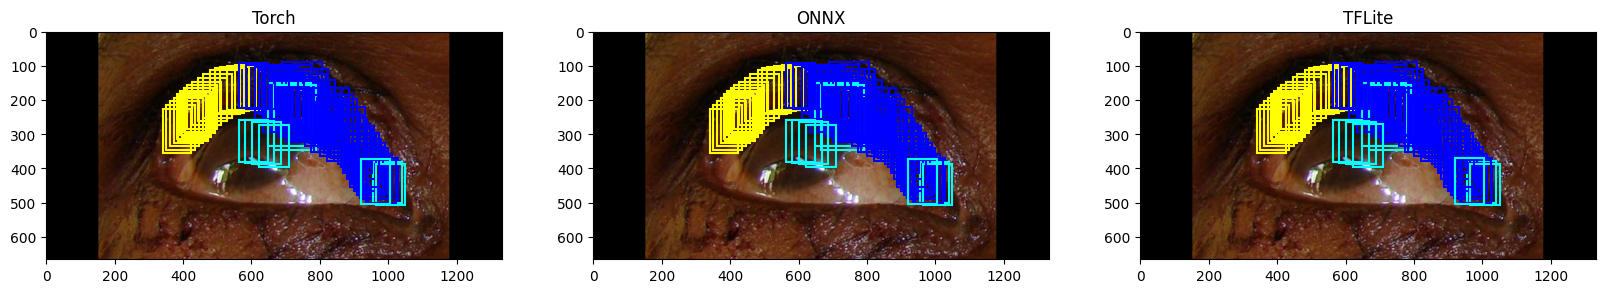

In [27]:
plt.figure(figsize=(20,10))

out_dict = [{'boxes':boxes_og.cpu().detach(), 'labels':labels_og.cpu().detach(),  'scores':scores_og.cpu().detach()}]
# out_dict = roi_head.faster.transform.postprocess(out_dict, roi_head.images_shapes, roi_head.og_sizes)
# out_dict = full_model.faster.transform.postprocess(out_dict, full_model.images_shapes, full_model.og_sizes)

preds_onnx = [{'boxes': torch.tensor(boxes_onnx),  'labels':labels_onnx, 'scores':scores_onnx }]
# preds_onnx = roi_head.faster.transform.postprocess([preds_onnx], roi_head.images_shapes, roi_head.og_sizes)
# preds_onnx = full_model.faster.transform.postprocess([preds_onnx], full_model.images_shapes, full_model.og_sizes)

preds_tf = [{'boxes': torch.tensor(boxes_tf)[:, [0,2,1,3]],  'labels':labels_tf, 'scores':scores_tf}]
# # preds_tf = roi_head.faster.transform.postprocess([preds_tf], roi_head.images_shapes, roi_head.og_sizes)
# outpreds_tf = full_model.faster.transform.postprocess([preds_tf], full_model.images_shapes, full_model.og_sizes)

plt.subplot(131)

plot_patches(example_input.permute(1,2,0), out_dict[0], title=f'Torch')
print(labels_og.numpy())

plt.subplot(132)
plot_patches(example_input.permute(1,2,0), preds_onnx[0], title=f'ONNX')
print(labels_onnx)

plt.subplot(133)
plot_patches(example_input.permute(1,2,0), preds_tf[0], title=f'TFLite')
print(labels_tf)

### Torch Script

In [ ]:
# Method 1: Script the model (recommended for most cases)
try:
    scripted_model = torch.jit.script(model_2)
    scripted_model.save('tt_faster_rcnn_mobile.pt')
    print("Model scripted successfully!")
except Exception as e:
    print(f"Scripting failed: {e}")

# Method 2: Trace the model (fallback)
try:
    traced_model = torch.jit.trace(model_2.cuda(), example_input.cuda())
    traced_model.save('tt_faster_rcnn_mobile_traced.pt')
    print("Model traced successfully!")
except Exception as e:
    print(f"Tracing also failed: {e}")

Scripting failed: Can't redefine method: forward on class: __torch__.nets.segmentation.CustomRoIHeads (of Python compilation unit at: 0x749c900)


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct 

Model traced successfully!


In [ ]:
# Optimize for mobile (optional but recommended)
from torch.utils.mobile_optimizer import optimize_for_mobile

try:
    scripted_model = torch.jit.script(model_2)
    optimized_model = optimize_for_mobile(traced_model)
    optimized_model._save_for_lite_interpreter('tt_faster_rcnn_optimized.ptl')
    print("Optimized model saved!")
except Exception as e:
    print(f"Optimization failed: {e}")

Optimization failed: Can't redefine method: forward on class: __torch__.nets.segmentation.CustomRoIHeads (of Python compilation unit at: 0x749c900)


In [ ]:
# Test the exported model
try:
    loaded_model = torch.jit.load("faster_rcnn_mobile_traced.pt")
    loaded_model.eval()
    test_input = torch.rand(3, 640, 640)
    
    with torch.no_grad():
        output = loaded_model(example_input.cuda())
    
except Exception as e:
    print(f"Test failed: {e}")

In [ ]:
output

(tensor([[ 743.8124,  209.8428,  822.9813,  328.2770],
         [ 715.3248,  186.6185,  797.4077,  306.2233],
         [ 690.3965,  162.3573,  771.8211,  278.6111],
         [ 582.5609,  587.1758,  665.6562,  703.9264],
         [ 613.7206,  585.2556,  693.4889,  700.3193],
         [1244.9928,  339.0969, 1319.0890,  453.7391],
         [1244.9896,  394.4460, 1319.0865,  509.0887],
         [1244.9923,  283.7450, 1319.0873,  398.3858],
         [1244.9933,  450.0866, 1318.9889,  564.4679],
         [1244.9818,  228.3851, 1319.0802,  343.0248],
         [1244.9928,  163.5793, 1319.3883,  278.1520],
         [ 249.3552,  450.0263,  323.3336,  564.3774],
         [ 258.4167,  403.5316,  332.4781,  518.0703],
         [ 258.4155,  348.1810,  332.4766,  462.7192],
         [ 258.4149,  292.8270,  332.4761,  407.3648],
         [ 258.4149,  237.4736,  332.4781,  352.0121],
         [ 212.3577,  256.0172,  286.9272,  370.5443],
         [ 212.3577,  311.3686,  286.9272,  425.8957],
         [